Image exists: True
GT .mat exists: True
Original image size (W,H): (832, 564)
Number of GT points: 507


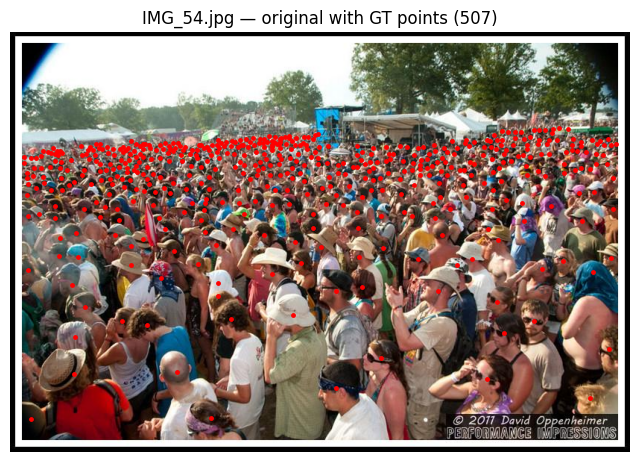

Resized image size: (1024, 768)
Example scaled point (first): [104.68732 624.68085]
Density full shape: (768, 1024) sum(counts) ~ 507.0


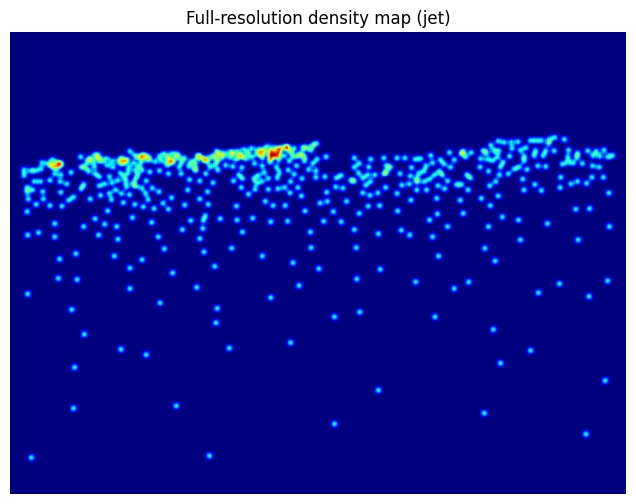

Downsampled density shape: (96, 128)
Sum of downsampled density: 507.75


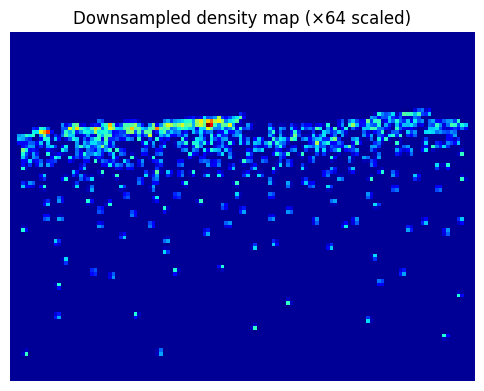

Image tensor shape: torch.Size([3, 768, 1024])
Density tensor shape: torch.Size([1, 96, 128])
Batch img: torch.Size([1, 3, 768, 1024])
Batch den: torch.Size([1, 1, 96, 128])
Saved resized image and density to: C:\Users\anany\OneDrive\Desktop\Deepvision-Crowd-Monitor\processed\partA
GT points: 507
Full density sum (float): 507.0
Downsampled density sum (×64 integral approx): 507.75
Full density sum: 507.0001
Downsampled density sum: 507.74786


In [76]:
# use these variables in the following cells
trainA_images = r"C:\Users\anany\OneDrive\Desktop\Deepvision-Crowd-Monitor\ShanghaiTech_Crowd_Counting_Dataset\part_A_final\train_data\images"
trainA_gts    = r"C:\Users\anany\OneDrive\Desktop\Deepvision-Crowd-Monitor\ShanghaiTech_Crowd_Counting_Dataset\part_A_final\train_data\ground_truth"

img_name = "IMG_54.jpg"
mat_name = "GT_IMG_54.mat"
import os

img_path = os.path.join(trainA_images, img_name)
mat_path = os.path.join(trainA_gts, mat_name)

print("Image exists:", os.path.exists(img_path))
print("GT .mat exists:", os.path.exists(mat_path))

import numpy as np
from PIL import Image
import scipy.io as sio
import cv2
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ImageNet normalization (for VGG/mentor)
img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

##Load image and GT points
# load image
img = Image.open(img_path).convert("RGB")
print("Original image size (W,H):", img.size)

# load .mat and points
mat = sio.loadmat(mat_path)
points = mat["image_info"][0][0][0][0][0]   # shape (N,2)
print("Number of GT points:", len(points))


###Display original image
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.scatter(points[:,0], points[:,1], s=6, c='red')
plt.title(f"{img_name} — original with GT points ({len(points)})")
plt.axis('off')
plt.show()

##Resize image to fixed size
# target size (mentor standard)
TARGET_W, TARGET_H = 1024, 768

# original
orig_w, orig_h = img.size

# resize image
img_resized = img.resize((TARGET_W, TARGET_H))   # (W, H)
print("Resized image size:", img_resized.size)

# scale GT points to match resized image:
scale_x = TARGET_W / orig_w
scale_y = TARGET_H / orig_h
points_scaled = points.copy().astype(np.float32)
points_scaled[:,0] = points_scaled[:,0] * scale_x
points_scaled[:,1] = points_scaled[:,1] * scale_y

print("Example scaled point (first):", points_scaled[0])

###Generate full-resolution 
def generate_density_map(points, h, w, ksize=(15,15), sigma=4):
    den = np.zeros((h, w), dtype=np.float32)
    if points is None or len(points)==0:
        return den
    for x, y in points:
        xi = min(w-1, max(0, int(round(x))))
        yi = min(h-1, max(0, int(round(y))))
        den[yi, xi] = 1.0
    # apply Gaussian blur to distribute head points
    den = cv2.GaussianBlur(den, ksize, sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REPLICATE)
    return den

# generate full-res density for the resized image
H, W = img_resized.size[1], img_resized.size[0]
density_full = generate_density_map(points_scaled, H, W)
print("Density full shape:", density_full.shape, "sum(counts) ~", density_full.sum().round(2))

##Visualize full-resolution 
plt.figure(figsize=(8,6))
plt.imshow(density_full, cmap='jet')
plt.title("Full-resolution density map (jet)")
plt.axis('off')
plt.show()

#Downsample density by 8x
ds_W, ds_H = W // 8, H // 8
density_ds = cv2.resize(density_full, (ds_W, ds_H), interpolation=cv2.INTER_CUBIC)
density_ds = density_ds * 64.0   # preserve counts per mentor
print("Downsampled density shape:", density_ds.shape)
print("Sum of downsampled density:", density_ds.sum().round(2))
#Visualize downsampled 
plt.figure(figsize=(6,5))
plt.imshow(density_ds, cmap='jet')
plt.title("Downsampled density map (×64 scaled)")
plt.axis('off')
plt.show()
#applyimagenet normalization

# image -> tensor & normalize
img_tensor = img_transform(img_resized)   # shape [3, H, W] -> [3,768,1024]
print("Image tensor shape:", img_tensor.shape)

# density -> tensor shape [1, H/8, W/8]
density_tensor = torch.from_numpy(density_ds).float().unsqueeze(0)
print("Density tensor shape:", density_tensor.shape)

#Create simple sample batch
# make a batch of size 1
batch_img = img_tensor.unsqueeze(0)     # [1,3,768,1024]
batch_den = density_tensor.unsqueeze(0) # [1,1,96,128]
print("Batch img:", batch_img.shape)
print("Batch den:", batch_den.shape)

#Save preproccessed outputs
out_dir = r"C:\Users\anany\OneDrive\Desktop\Deepvision-Crowd-Monitor\processed\partA"
os.makedirs(out_dir, exist_ok=True)

# save resized image (as PNG) and density (as .npy)
img_resized.save(os.path.join(out_dir, img_name.replace('.jpg','.png')))
np.save(os.path.join(out_dir, img_name.replace('.jpg','_den.npy')), density_ds)

print("Saved resized image and density to:", out_dir)

#Counts and sums
print("GT points:", len(points))
print("Full density sum (float):", density_full.sum().round(2))
print("Downsampled density sum (×64 integral approx):", density_ds.sum().round(2))

print("Full density sum:", density_full.sum())
print("Downsampled density sum:", density_ds.sum())
